In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("senju14/ocr-dataset-of-multi-type-documents")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ocr-dataset-of-multi-type-documents' dataset.
Path to dataset files: /kaggle/input/ocr-dataset-of-multi-type-documents


In [ ]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch torchvision opencv-python pillow numpy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import cv2
import os
from pathlib import Path
from google.colab import drive

In [ ]:
# CELL 3: Define Character Set and Dataset Class
CHARSET = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz !\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
CHAR_TO_IDX = {c: i for i, c in enumerate(CHARSET)}
IDX_TO_CHAR = {i: c for c, i in CHAR_TO_IDX.items()}

print(f"Character set size: {len(CHARSET)}")

class CustomOCRDataset(Dataset):
    """Load custom OCR dataset"""
    def __init__(self, data_dir, labels_file, transform=None, img_size=256):
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform if transform else self.default_transform()
        self.images = []
        self.labels = []

        with open(labels_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split(maxsplit=1)  # Split into at most 2 parts
                if len(parts) >= 2:
                    img_name = parts[0]
                    label = parts[1]
                    img_path = os.path.join(data_dir, img_name)
                    if os.path.exists(img_path):
                        self.images.append(img_path)
                        self.labels.append(label)

    def default_transform(self):
        """Default transform that resizes images to fixed size"""
        return transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        try:
            img = Image.open(img_path).convert('L')
            img = self.transform(img)

            # Convert first character of label to index
            label_idx = CHAR_TO_IDX.get(label[0], 0)
            return img, label_idx
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a blank image and default label on error
            blank_img = Image.new('L', (self.img_size, self.img_size), color=255)
            img = self.transform(blank_img)
            label_idx = CHAR_TO_IDX.get('A', 0)
            return img, label_idx

print("Dataset class defined!")

Character set size: 95
Dataset class defined!


In [ ]:
# Force recreate model fresh
class OCRModel(nn.Module):
    def __init__(self, num_classes, input_size=256):
        super(OCRModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.flat_size = 256 * 16 * 16  # 65536

        self.classifier = nn.Sequential(
            nn.Linear(self.flat_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

print("Model redefined")

# Now recreate OCR system
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ocr = OCRSystem(device=device, input_size=256)
print(f"OCR recreated with flat_size={ocr.model.flat_size}")

Model redefined
OCR recreated with flat_size=65536


In [ ]:
# CELL 5: Define OCR System Class
class OCRSystem:
    def __init__(self, device='cpu', input_size=256):
        self.device = device
        self.input_size = input_size
        self.model = OCRModel(len(CHARSET), input_size).to(device)
        self.transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def train(self, train_loader, val_loader=None, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        self.model.train()
        best_acc = 0

        for epoch in range(epochs):
            total_loss = 0
            for images, labels in train_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

            if val_loader:
                acc = self.evaluate(val_loader)
                if acc > best_acc:
                    best_acc = acc
                    self.save_model('/content/drive/MyDrive/best_ocr_model.pth')

            scheduler.step()

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'  Validation Accuracy: {accuracy:.2f}% ({correct}/{total})')
        return accuracy

    def recognize_image(self, image_path):
        img = Image.open(image_path).convert('L')
        img_tensor = self.transform(img).unsqueeze(0).to(self.device)

        self.model.eval()
        with torch.no_grad():
            output = self.model(img_tensor)
            _, predicted = torch.max(output, 1)
            confidence = torch.softmax(output, dim=1)[0, predicted.item()].item()

        char = IDX_TO_CHAR[predicted.item()]
        return char, confidence

    def recognize_text_region(self, image_path, region_coords=None):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if region_coords:
            x1, y1, x2, y2 = region_coords
            img = img[y1:y2, x1:x2]

        chars = []
        confidences = []
        self.model.eval()

        _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

        with torch.no_grad():
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                if w > 5 and h > 5:
                    char_img = binary[y:y+h, x:x+w]
                    char_img = cv2.resize(char_img, (self.input_size, self.input_size))
                    char_tensor = self.transform(Image.fromarray(char_img)).unsqueeze(0).to(self.device)

                    output = self.model(char_tensor)
                    _, predicted = torch.max(output, 1)
                    confidence = torch.softmax(output, dim=1)[0, predicted.item()].item()

                    chars.append(IDX_TO_CHAR[predicted.item()])
                    confidences.append(confidence)

        return ''.join(chars), confidences

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        print(f"Model loaded from {path}")

print("OCR System class defined!")

OCR System class defined!


In [ ]:
print("Downloading Kaggle OCR dataset...")
dataset_path = kagglehub.dataset_download("senju14/ocr-dataset-of-multi-type-documents")
print(f"Dataset downloaded to: {dataset_path}")

print("\nDataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files) - 5} more files')

Using Colab cache for faster access to the 'ocr-dataset-of-multi-type-documents' dataset.
Dataset downloaded to: /kaggle/input/ocr-dataset-of-multi-type-documents

Dataset structure:
ocr-dataset-of-multi-type-documents/
  real_life/
    val/
      annotations/
        poly_gt_img868.txt
        poly_gt_img1276.txt
        poly_gt_img417.txt
        poly_gt_img99.txt
        poly_gt_img1254.txt
        ... and 151 more files
      images/
        img1493.jpg
        img514.jpg
        img331.jpg
        img476.jpg
        img1479.jpg
        ... and 151 more files
    test/
      annotations/
        poly_gt_img290.txt
        poly_gt_img1166.txt
        poly_gt_img1002.txt
        poly_gt_img483.txt
        poly_gt_img711.txt
        ... and 150 more files
      images/
        img1138.jpg
        img170.jpg
        img521.jpg
        img551.jpg
        img290.jpg
        ... and 150 more files
    train/
      annotations/
        poly_gt_img1349.txt
        poly_gt_img415.txt
       

In [ ]:
# CELL 7: Find Dataset Paths and Explore Structure
print("Exploring dataset structure...")

train_data_dir = None
train_annotations_dir = None
val_data_dir = None
val_annotations_dir = None

# Search for train and val directories
for root, dirs, files in os.walk(dataset_path):
    if 'train' in root.lower():
        if 'images' in dirs:
            train_data_dir = os.path.join(root, 'images')
        if 'annotations' in dirs:
            train_annotations_dir = os.path.join(root, 'annotations')

    if 'val' in root.lower():
        if 'images' in dirs:
            val_data_dir = os.path.join(root, 'images')
        if 'annotations' in dirs:
            val_annotations_dir = os.path.join(root, 'annotations')

print(f"Found structure:")
print(f"Train images: {train_data_dir}")
print(f"Train annotations: {train_annotations_dir}")
print(f"Val images: {val_data_dir}")
print(f"Val annotations: {val_annotations_dir}")

# Show sample annotation files
if train_annotations_dir and os.path.exists(train_annotations_dir):
    print(f"\nSample annotation files in train:")
    sample_annot = os.listdir(train_annotations_dir)[:3]
    for f in sample_annot:
        print(f"  - {f}")

# Create labels file from annotations
def create_labels_from_annotations(images_dir, annotations_dir, output_labels_file):
    """Create labels file from annotation files"""
    labels = []

    # Get all image files
    image_files = set()
    for img_file in os.listdir(images_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
            image_files.add(img_file)

    # Map images to their annotations
    for annot_file in os.listdir(annotations_dir):
        if annot_file.lower().endswith(('.txt', '.xml', '.json')):
            # Find corresponding image
            # Try different naming conventions
            base_name = os.path.splitext(annot_file)[0]

            # Check for image with same base name
            img_file = None
            for ext in ['.jpg', '.jpeg', '.png', '.gif']:
                if base_name + ext in image_files:
                    img_file = base_name + ext
                    break

            if img_file:
                annot_path = os.path.join(annotations_dir, annot_file)

                # Read annotation file
                try:
                    with open(annot_path, 'r', encoding='utf-8') as f:
                        content = f.read().strip()
                        # Extract first character/word from annotation
                        if content:
                            label = content.split()[0] if ' ' in content else content[0]
                            labels.append(f"{img_file} {label}")
                except Exception as e:
                    print(f"Error reading {annot_file}: {e}")

    with open(output_labels_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(labels))

    print(f"Created labels file with {len(labels)} entries")
    return output_labels_file, labels

# Create labels directory in /tmp (writable location)
labels_output_dir = '/tmp/ocr_labels'
os.makedirs(labels_output_dir, exist_ok=True)

# Updated function for JSON annotations with ocr_boxes
def create_labels_from_json_annotations(images_dir, annotations_dir, output_labels_file):
    """Create labels file from JSON annotation files with ocr_boxes"""
    import json
    labels = []

    # Get all image files
    image_files = set()
    for img_file in os.listdir(images_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
            image_files.add(img_file)

    # Map images to their annotations
    for annot_file in os.listdir(annotations_dir):
        if annot_file.lower().endswith('.json'):
            base_name = os.path.splitext(annot_file)[0]

            # Find corresponding image
            img_file = None
            for ext in ['.jpg', '.jpeg', '.png', '.gif']:
                if base_name + ext in image_files:
                    img_file = base_name + ext
                    break

            if img_file:
                annot_path = os.path.join(annotations_dir, annot_file)

                try:
                    with open(annot_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                        # Extract text from ocr_boxes
                        texts = []
                        if 'ocr_boxes' in data:
                            for box in data['ocr_boxes']:
                                if 'text' in box:
                                    texts.append(box['text'])

                        # Combine all text
                        full_text = ' '.join(texts)

                        if full_text:
                            labels.append(f"{img_file} {full_text}")
                except Exception as e:
                    print(f"Error reading {annot_file}: {e}")

    with open(output_labels_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(labels))

    print(f"Created labels file with {len(labels)} entries")
    return output_labels_file, labels

# Create labels for train
if train_data_dir and train_annotations_dir and os.path.exists(train_data_dir) and os.path.exists(train_annotations_dir):
    train_labels = os.path.join(labels_output_dir, 'train_labels.txt')
    print("\nCreating train labels from JSON annotations...")
    train_labels, train_label_samples = create_labels_from_json_annotations(train_data_dir, train_annotations_dir, train_labels)
    print(f"Sample train labels:")
    for sample in train_label_samples[:3]:
        print(f"  {sample[:100]}...")  # Print first 100 chars
else:
    train_labels = None
    print("Train data or annotations not found!")

# Create labels for val
if val_data_dir and val_annotations_dir and os.path.exists(val_data_dir) and os.path.exists(val_annotations_dir):
    val_labels = os.path.join(labels_output_dir, 'val_labels.txt')
    print("\nCreating val labels from JSON annotations...")
    val_labels, val_label_samples = create_labels_from_json_annotations(val_data_dir, val_annotations_dir, val_labels)
    print(f"Sample val labels:")
    for sample in val_label_samples[:3]:
        print(f"  {sample[:100]}...")  # Print first 100 chars
else:
    val_labels = None
    print("Val data or annotations not found!")

print(f"\nFinal Dataset Paths:")
print(f"Train images: {train_data_dir}")
print(f"Train labels: {train_labels}")
print(f"Val images: {val_data_dir}")
print(f"Val labels: {val_labels}")

Exploring dataset structure...
Found structure:
Train images: /kaggle/input/ocr-dataset-of-multi-type-documents/invoice/train/images
Train annotations: /kaggle/input/ocr-dataset-of-multi-type-documents/invoice/train/annotations
Val images: /kaggle/input/ocr-dataset-of-multi-type-documents/invoice/val/images
Val annotations: /kaggle/input/ocr-dataset-of-multi-type-documents/invoice/val/annotations

Sample annotation files in train:
  - X51006414470.json
  - X51008099054.json
  - X51006619785.json

Creating train labels from JSON annotations...
Created labels file with 778 entries
Sample train labels:
  X51006414470.jpg UNIHAKKA INTERNATIONAL SDN BHD 09 APR 2018 18:26 (867388-U) 12, JALAN TAMPOI 7/4,KA...
  X51008099054.jpg 10 GRAM GOURMET SBN BHD (1152264-K) NO 3, JALAN TEMENGGUNG 27/9 BANDAR MAHKOTA CHER...
  X51006619785.jpg ECOSWAY.COM SDN BHD (509213A) 2ND FLOOR, WISMA COSWAY, JALAN RAJA CHULAN, 50200 KUA...

Creating val labels from JSON annotations...
Created labels file with 97 e

In [ ]:
# CELL 8: Load Dataset
print("Loading dataset...")
train_dataset = CustomOCRDataset(train_data_dir, train_labels)
val_dataset = CustomOCRDataset(val_data_dir, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Total training samples: {len(train_dataset)}")
print(f"Total validation samples: {len(val_dataset)}")
print(f"Batch size: 32")


Loading dataset...
Total training samples: 778
Total validation samples: 97
Batch size: 32


In [ ]:
# CELL 9: Initialize OCR System
print("Initializing OCR System...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create fresh model instance
ocr = OCRSystem(device=device, input_size=256)
print(f"Model created with input size: 256x256")
print(f"Total parameters: {sum(p.numel() for p in ocr.model.parameters()):,}")
print("OCR System ready for training!\n")

Initializing OCR System...
Using device: cpu
Model created with input size: 256x256
Total parameters: 34,099,487
OCR System ready for training!



In [ ]:
# DEBUG: Check model input/output shapes
print("Model structure:")
print(ocr.model)
print(f"\nInput size: 256x256")

# Test with a single batch
test_images, test_labels = next(iter(train_loader))
print(f"Batch shape: {test_images.shape}")
print(f"Labels shape: {test_labels.shape}")

test_images = test_images.to(device)
try:
    with torch.no_grad():
        output = ocr.model(test_images)
    print(f"Output shape: {output.shape}")
    print("✓ Model forward pass successful!")
except Exception as e:
    print(f"✗ Error in forward pass: {e}")

Model structure:
OCRModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, 

In [ ]:
# CELL 10: Train Model with Detailed Accuracy Tracking
print("Starting training...")
print("="*60)

# Add accuracy tracking
class OCRSystemWithTracking(OCRSystem):
    def train(self, train_loader, val_loader=None, epochs=20, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        self.model.train()
        best_acc = 0
        history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(epochs):
            total_loss = 0
            for images, labels in train_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            history['train_loss'].append(avg_loss)

            print(f'\nEpoch [{epoch+1}/{epochs}]')
            print(f'  Train Loss: {avg_loss:.4f}')

            # Validate
            if val_loader:
                self.model.eval()
                val_loss = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in val_loader:
                        images = images.to(self.device)
                        labels = labels.to(self.device)
                        outputs = self.model(images)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()

                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                val_loss /= len(val_loader)
                val_acc = 100 * correct / total
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)

                print(f'  Validation Loss: {val_loss:.4f}')
                print(f'  Validation Accuracy: {val_acc:.2f}%')

                if val_acc > best_acc:
                    best_acc = val_acc
                    self.save_model('/content/drive/MyDrive/best_ocr_model.pth')
                    print(f'  ✓ Best model updated! (Accuracy: {val_acc:.2f}%)')

                self.model.train()

            scheduler.step()

        print("\n" + "="*60)
        print("TRAINING SUMMARY")
        print("="*60)
        print(f'Final Train Loss: {history["train_loss"][-1]:.4f}')
        if val_loader:
            print(f'Final Validation Loss: {history["val_loss"][-1]:.4f}')
            print(f'Final Validation Accuracy: {history["val_acc"][-1]:.2f}%')
            print(f'Best Validation Accuracy: {max(history["val_acc"]):.2f}%')
        print("="*60)

        return history

# Create new system with tracking
ocr = OCRSystemWithTracking(device=device, input_size=28)
print("OCR System initialized with accuracy tracking!\n")

# Train
history = ocr.train(train_loader, val_loader, epochs=20, lr=0.001)
print("\nTraining complete!")

Starting training...
OCR System initialized with accuracy tracking!


Epoch [1/20]
  Train Loss: 7.7828
  Validation Loss: 4.0677
  Validation Accuracy: 6.19%
Model saved to /content/drive/MyDrive/best_ocr_model.pth
  ✓ Best model updated! (Accuracy: 6.19%)

Epoch [2/20]
  Train Loss: 3.6069
  Validation Loss: 2.9231
  Validation Accuracy: 34.02%
Model saved to /content/drive/MyDrive/best_ocr_model.pth
  ✓ Best model updated! (Accuracy: 34.02%)

Epoch [3/20]
  Train Loss: 2.9702
  Validation Loss: 2.8046
  Validation Accuracy: 23.71%

Epoch [4/20]
  Train Loss: 2.7218
  Validation Loss: 2.6887
  Validation Accuracy: 38.14%
Model saved to /content/drive/MyDrive/best_ocr_model.pth
  ✓ Best model updated! (Accuracy: 38.14%)

Epoch [5/20]
  Train Loss: 2.5692
  Validation Loss: 2.5999
  Validation Accuracy: 26.80%

Epoch [6/20]
  Train Loss: 2.3926
  Validation Loss: 2.4605
  Validation Accuracy: 40.21%
Model saved to /content/drive/MyDrive/best_ocr_model.pth
  ✓ Best model updated! (Accur

Calculating Character Error Rate and preparing plots...
Metrics calculated!
Plot saved to Google Drive as training_history.png!


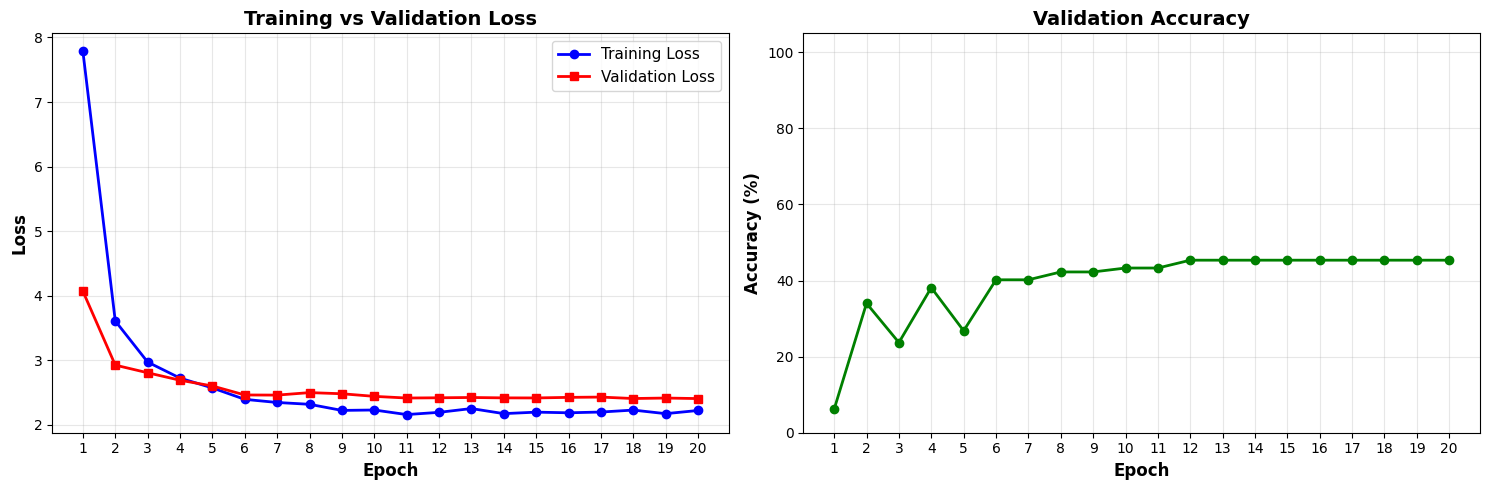


DETAILED TRAINING & EVALUATION STATISTICS

TRAINING LOSS:
  Initial (Epoch 1): 7.7828
  Final (Epoch 20): 2.2201
  Improvement: 5.5627

VALIDATION LOSS (from training history):
  Initial (Epoch 1): 4.0677
  Final (Epoch 20): 2.4046
  Improvement: 1.6631
  Best: 2.4046 (Epoch 20)

VALIDATION ACCURACY (from training history):
  Initial (Epoch 1): 6.19%
  Final (Epoch 20): 45.36%
  Best: 45.36% (Epoch 12)
  Improvement: 39.18%

CHARACTER RECOGNITION METRICS (Final Model):
  Character Accuracy: 45.36%
  Character Error Rate (CER): 54.64%
  Correct Characters: 44/97
  Incorrect Characters: 53/97



In [ ]:
# CELL 11: Calculate Character Error Rate and Plot Training History
import matplotlib.pyplot as plt

print("Calculating Character Error Rate and preparing plots...")

# Extract predictions and targets from validation set using final model
all_predictions = []
all_targets = []

ocr.model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = ocr.model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Calculate Character Error Rate (CER)
correct_chars = sum(1 for p, t in zip(all_predictions, all_targets) if p == t)
total_chars = len(all_targets)
cer = 100 * (1 - correct_chars / total_chars) if total_chars > 0 else 100
character_accuracy = 100 * correct_chars / total_chars if total_chars > 0 else 0

print("Metrics calculated!")

# Create plots using stored history from training
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss vs Validation Loss
epochs = range(1, len(history['train_loss'])+1)
axes[0].plot(epochs, history['train_loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs, history['val_loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(epochs)

# Plot 2: Validation Accuracy
axes[1].plot(epochs, history['val_acc'], 'g-o', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(epochs)
axes[1].set_ylim([0, 105])

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/training_history.png', dpi=300, bbox_inches='tight')
print("Plot saved to Google Drive as training_history.png!")
plt.show()

# Print detailed statistics (using stored history)
print("\n" + "="*70)
print("DETAILED TRAINING & EVALUATION STATISTICS")
print("="*70)

print("\nTRAINING LOSS:")
print(f"  Initial (Epoch 1): {history['train_loss'][0]:.4f}")
print(f"  Final (Epoch {len(history['train_loss'])}): {history['train_loss'][-1]:.4f}")
print(f"  Improvement: {history['train_loss'][0] - history['train_loss'][-1]:.4f}")

print("\nVALIDATION LOSS (from training history):")
print(f"  Initial (Epoch 1): {history['val_loss'][0]:.4f}")
print(f"  Final (Epoch {len(history['val_loss'])}): {history['val_loss'][-1]:.4f}")
print(f"  Improvement: {history['val_loss'][0] - history['val_loss'][-1]:.4f}")
print(f"  Best: {min(history['val_loss']):.4f} (Epoch {history['val_loss'].index(min(history['val_loss']))+1})")

print("\nVALIDATION ACCURACY (from training history):")
print(f"  Initial (Epoch 1): {history['val_acc'][0]:.2f}%")
print(f"  Final (Epoch {len(history['val_acc'])}): {history['val_acc'][-1]:.2f}%")
best_epoch = history['val_acc'].index(max(history['val_acc'])) + 1
print(f"  Best: {max(history['val_acc']):.2f}% (Epoch {best_epoch})")
print(f"  Improvement: {history['val_acc'][-1] - history['val_acc'][0]:.2f}%")

print("\nCHARACTER RECOGNITION METRICS (Final Model):")
print(f"  Character Accuracy: {character_accuracy:.2f}%")
print(f"  Character Error Rate (CER): {cer:.2f}%")
print(f"  Correct Characters: {correct_chars}/{total_chars}")
print(f"  Incorrect Characters: {total_chars - correct_chars}/{total_chars}")

print("\n" + "="*70)

In [ ]:
# CELL 11: Save Final Model
ocr.save_model('/content/drive/MyDrive/ocr_model_final.pth')
print("Final model saved to Google Drive!")

Model saved to /content/drive/MyDrive/ocr_model_final.pth
Final model saved to Google Drive!


In [ ]:
print("Loading saved model and continuing training...")
print("="*60)

# Load the best saved model
saved_model_path = '/content/drive/MyDrive/best_ocr_model.pth'
ocr.model.load_state_dict(torch.load(saved_model_path, map_location=device))
print("✓ Best model loaded successfully!\n")

# Fine-tuning with lower learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ocr.model.parameters(), lr=0.0001)  # Learning rate أقل
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

additional_epochs = 20  # عدد الـ epochs الإضافية (غيرها حسب احتياجك)
best_acc = max(history['val_acc'])  # أفضل accuracy من التدريب السابق

print(f"Previous best accuracy: {best_acc:.2f}%")
print(f"Starting fine-tuning for {additional_epochs} more epochs...\n")

for epoch in range(additional_epochs):
    # Training phase
    ocr.model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = ocr.model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    history['train_loss'].append(avg_loss)

    current_epoch = len(history['train_loss'])
    print(f'\nEpoch [{current_epoch}]')
    print(f'  Train Loss: {avg_loss:.4f}')

    # Validation phase
    ocr.model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = ocr.model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'  Validation Loss: {val_loss:.4f}')
    print(f'  Validation Accuracy: {val_acc:.2f}%')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(ocr.model.state_dict(), '/content/drive/MyDrive/best_ocr_model.pth')
        print(f'  ✓ Best model updated! (New best: {val_acc:.2f}%)')

    scheduler.step()

print("\n" + "="*60)
print("FINE-TUNING SUMMARY")
print("="*60)
print(f'Final Train Loss: {history["train_loss"][-1]:.4f}')
print(f'Final Validation Loss: {history["val_loss"][-1]:.4f}')
print(f'Final Validation Accuracy: {history["val_acc"][-1]:.2f}%')
print(f'Best Validation Accuracy: {max(history["val_acc"]):.2f}%')
print("="*60)
print("Fine-tuning complete!")

Loading saved model and continuing training...
✓ Best model loaded successfully!

Previous best accuracy: 45.36%
Starting fine-tuning for 20 more epochs...


Epoch [21]
  Train Loss: 2.1466
  Validation Loss: 2.3625
  Validation Accuracy: 44.33%

Epoch [22]
  Train Loss: 2.1725
  Validation Loss: 2.4125
  Validation Accuracy: 45.36%

Epoch [23]
  Train Loss: 2.0730
  Validation Loss: 2.4299
  Validation Accuracy: 45.36%

Epoch [24]
  Train Loss: 2.0672
  Validation Loss: 2.4151
  Validation Accuracy: 48.45%
  ✓ Best model updated! (New best: 48.45%)

Epoch [25]
  Train Loss: 2.0485
  Validation Loss: 2.3476
  Validation Accuracy: 47.42%

Epoch [26]
  Train Loss: 2.0351
  Validation Loss: 2.3424
  Validation Accuracy: 47.42%

Epoch [27]
  Train Loss: 2.0581
  Validation Loss: 2.3415
  Validation Accuracy: 48.45%

Epoch [28]
  Train Loss: 2.0404
  Validation Loss: 2.3598
  Validation Accuracy: 47.42%

Epoch [29]
  Train Loss: 2.0111
  Validation Loss: 2.3597
  Validation Accuracy: 47.42%

Calculating Character Error Rate and preparing plots...
Metrics calculated!
Plot saved to Google Drive as training_history.png!


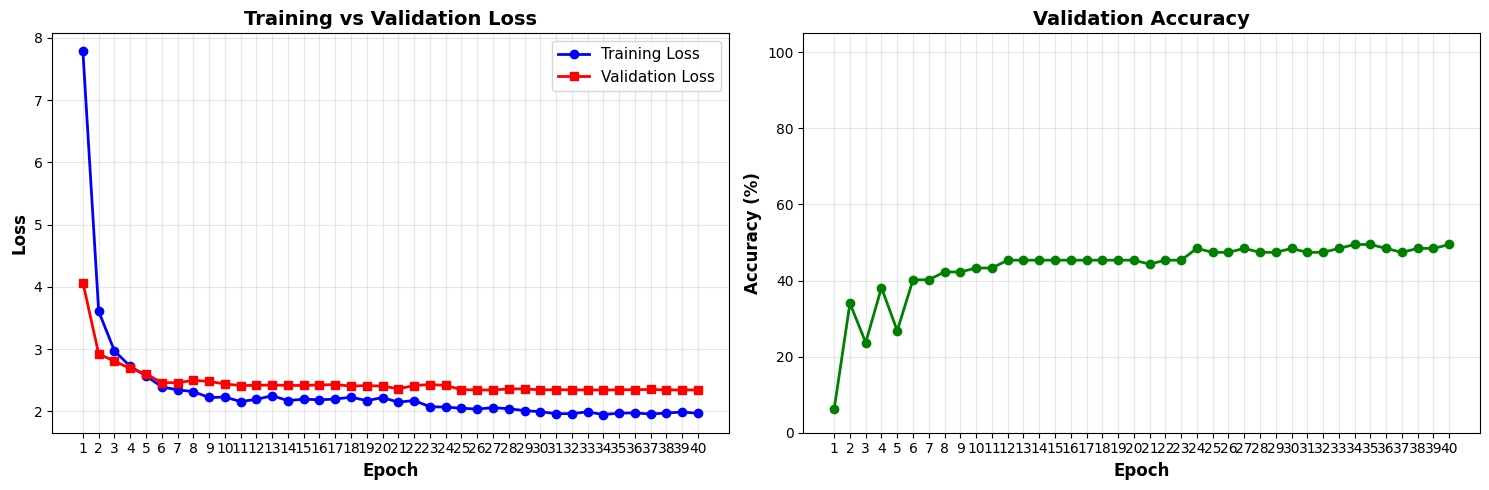


DETAILED TRAINING & EVALUATION STATISTICS

TRAINING LOSS:
  Initial (Epoch 1): 7.7828
  Final (Epoch 40): 1.9671
  Improvement: 5.8157

VALIDATION LOSS (from training history):
  Initial (Epoch 1): 4.0677
  Final (Epoch 40): 2.3444
  Improvement: 1.7233
  Best: 2.3415 (Epoch 27)

VALIDATION ACCURACY (from training history):
  Initial (Epoch 1): 6.19%
  Final (Epoch 40): 49.48%
  Best: 49.48% (Epoch 34)
  Improvement: 43.30%

CHARACTER RECOGNITION METRICS (Final Model):
  Character Accuracy: 49.48%
  Character Error Rate (CER): 50.52%
  Correct Characters: 48/97
  Incorrect Characters: 49/97



In [ ]:
import matplotlib.pyplot as plt

print("Calculating Character Error Rate and preparing plots...")

# Extract predictions and targets from validation set using final model
all_predictions = []
all_targets = []

ocr.model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = ocr.model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Calculate Character Error Rate (CER)
correct_chars = sum(1 for p, t in zip(all_predictions, all_targets) if p == t)
total_chars = len(all_targets)
cer = 100 * (1 - correct_chars / total_chars) if total_chars > 0 else 100
character_accuracy = 100 * correct_chars / total_chars if total_chars > 0 else 0

print("Metrics calculated!")

# Create plots using stored history from training
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss vs Validation Loss
epochs = range(1, len(history['train_loss'])+1)
axes[0].plot(epochs, history['train_loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs, history['val_loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(epochs)

# Plot 2: Validation Accuracy
axes[1].plot(epochs, history['val_acc'], 'g-o', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(epochs)
axes[1].set_ylim([0, 105])

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/training_history.png', dpi=300, bbox_inches='tight')
print("Plot saved to Google Drive as training_history.png!")
plt.show()

# Print detailed statistics (using stored history)
print("\n" + "="*70)
print("DETAILED TRAINING & EVALUATION STATISTICS")
print("="*70)

print("\nTRAINING LOSS:")
print(f"  Initial (Epoch 1): {history['train_loss'][0]:.4f}")
print(f"  Final (Epoch {len(history['train_loss'])}): {history['train_loss'][-1]:.4f}")
print(f"  Improvement: {history['train_loss'][0] - history['train_loss'][-1]:.4f}")

print("\nVALIDATION LOSS (from training history):")
print(f"  Initial (Epoch 1): {history['val_loss'][0]:.4f}")
print(f"  Final (Epoch {len(history['val_loss'])}): {history['val_loss'][-1]:.4f}")
print(f"  Improvement: {history['val_loss'][0] - history['val_loss'][-1]:.4f}")
print(f"  Best: {min(history['val_loss']):.4f} (Epoch {history['val_loss'].index(min(history['val_loss']))+1})")

print("\nVALIDATION ACCURACY (from training history):")
print(f"  Initial (Epoch 1): {history['val_acc'][0]:.2f}%")
print(f"  Final (Epoch {len(history['val_acc'])}): {history['val_acc'][-1]:.2f}%")
best_epoch = history['val_acc'].index(max(history['val_acc'])) + 1
print(f"  Best: {max(history['val_acc']):.2f}% (Epoch {best_epoch})")
print(f"  Improvement: {history['val_acc'][-1] - history['val_acc'][0]:.2f}%")

print("\nCHARACTER RECOGNITION METRICS (Final Model):")
print(f"  Character Accuracy: {character_accuracy:.2f}%")
print(f"  Character Error Rate (CER): {cer:.2f}%")
print(f"  Correct Characters: {correct_chars}/{total_chars}")
print(f"  Incorrect Characters: {total_chars - correct_chars}/{total_chars}")

print("\n" + "="*70)

In [ ]:
save_path = '/content/drive/MyDrive/best_ocr_model_v2.pth'

# Save the model
torch.save(ocr.model.state_dict(), save_path)

print(f"✓ Model saved successfully!")
print(f"  Name: best_ocr_model_v2.pth")
print(f"  Path: {save_path}")

✓ Model saved successfully!
  Name: best_ocr_model_v2.pth
  Path: /content/drive/MyDrive/best_ocr_model_v2.pth


In [ ]:
print("Loading saved model and continuing training...")
print("="*60)

# Load the best saved model
saved_model_path = '/content/drive/MyDrive/best_ocr_model_v2.pth'
ocr.model.load_state_dict(torch.load(saved_model_path, map_location=device))
print("✓ Best model loaded successfully!\n")

# Fine-tuning with lower learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ocr.model.parameters(), lr=0.0001)  # Learning rate أقل
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

additional_epochs = 30  # عدد الـ epochs الإضافية (غيرها حسب احتياجك)
best_acc = max(history['val_acc'])  # أفضل accuracy من التدريب السابق

print(f"Previous best accuracy: {best_acc:.2f}%")
print(f"Starting fine-tuning for {additional_epochs} more epochs...\n")

for epoch in range(additional_epochs):
    # Training phase
    ocr.model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = ocr.model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    history['train_loss'].append(avg_loss)

    current_epoch = len(history['train_loss'])
    print(f'\nEpoch [{current_epoch}]')
    print(f'  Train Loss: {avg_loss:.4f}')

    # Validation phase
    ocr.model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = ocr.model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'  Validation Loss: {val_loss:.4f}')
    print(f'  Validation Accuracy: {val_acc:.2f}%')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(ocr.model.state_dict(), '/content/drive/MyDrive/best_ocr_model_v2.pth')
        print(f'  ✓ Best model updated! (New best: {val_acc:.2f}%)')

    scheduler.step()

print("\n" + "="*60)
print("FINE-TUNING SUMMARY")
print("="*60)
print(f'Final Train Loss: {history["train_loss"][-1]:.4f}')
print(f'Final Validation Loss: {history["val_loss"][-1]:.4f}')
print(f'Final Validation Accuracy: {history["val_acc"][-1]:.2f}%')
print(f'Best Validation Accuracy: {max(history["val_acc"]):.2f}%')
print("="*60)
print("Fine-tuning complete!")

Loading saved model and continuing training...
✓ Best model loaded successfully!

Previous best accuracy: 49.48%
Starting fine-tuning for 30 more epochs...


Epoch [41]
  Train Loss: 2.0337
  Validation Loss: 2.3070
  Validation Accuracy: 50.52%
  ✓ Best model updated! (New best: 50.52%)

Epoch [42]
  Train Loss: 1.9543
  Validation Loss: 2.2822
  Validation Accuracy: 49.48%

Epoch [43]
  Train Loss: 1.9046
  Validation Loss: 2.3182
  Validation Accuracy: 50.52%

Epoch [44]
  Train Loss: 1.8753
  Validation Loss: 2.2036
  Validation Accuracy: 56.70%
  ✓ Best model updated! (New best: 56.70%)

Epoch [45]
  Train Loss: 1.8192
  Validation Loss: 2.2665
  Validation Accuracy: 54.64%

Epoch [46]
  Train Loss: 1.8229
  Validation Loss: 2.2822
  Validation Accuracy: 53.61%

Epoch [47]
  Train Loss: 1.7555
  Validation Loss: 2.2657
  Validation Accuracy: 53.61%

Epoch [48]
  Train Loss: 1.8286
  Validation Loss: 2.2713
  Validation Accuracy: 53.61%

Epoch [49]
  Train Loss: 1.8431
  Validation

Calculating Character Error Rate and preparing plots...
Metrics calculated!
Plot saved to Google Drive as training_history.png!


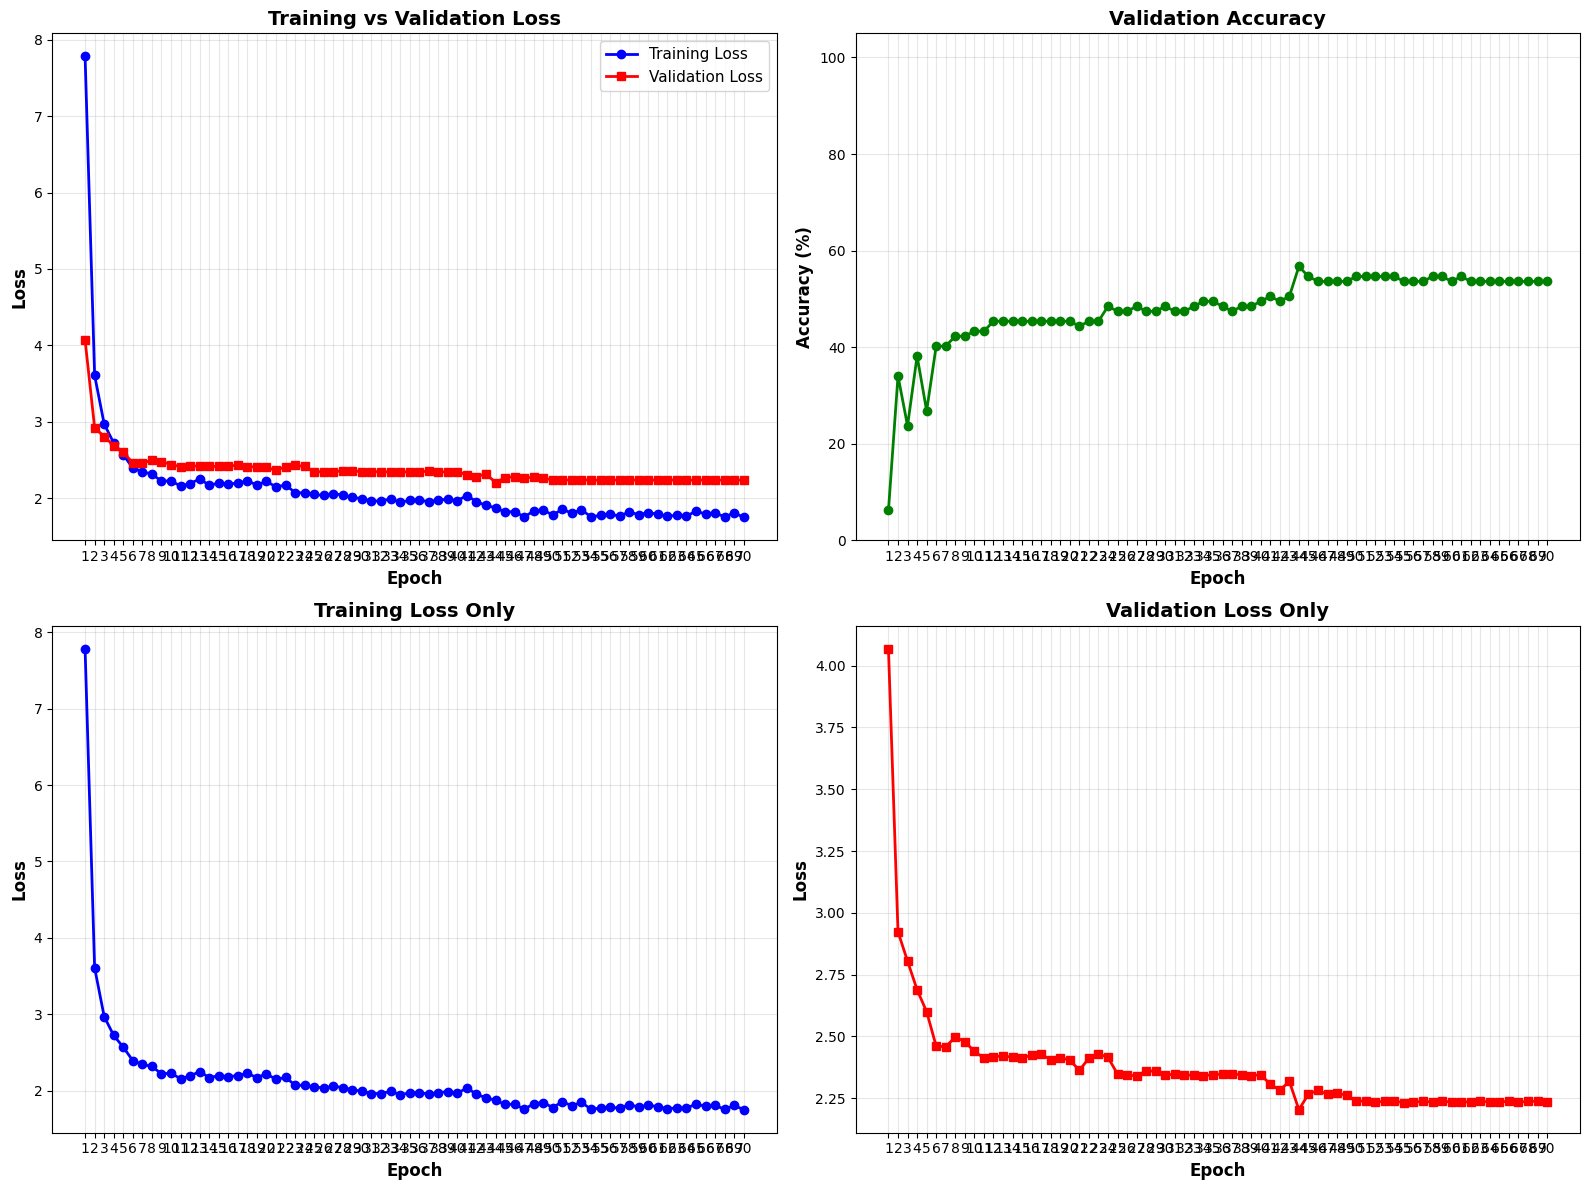


DETAILED TRAINING & EVALUATION STATISTICS

TRAINING LOSS:
  Initial (Epoch 1): 7.7828
  Final (Epoch 70): 1.7505
  Improvement: 6.0323
  Best: 1.7505 (Epoch 70)

VALIDATION LOSS (from training history):
  Initial (Epoch 1): 4.0677
  Final (Epoch 70): 2.2360
  Improvement: 1.8317
  Best: 2.2036 (Epoch 44)

VALIDATION ACCURACY (from training history):
  Initial (Epoch 1): 6.19%
  Final (Epoch 70): 53.61%
  Best: 56.70% (Epoch 44)
  Improvement: 47.42%

CHARACTER RECOGNITION METRICS (Final Model):
  Character Accuracy: 53.61%
  Character Error Rate (CER): 46.39%
  Correct Characters: 52/97
  Incorrect Characters: 45/97



In [ ]:

# CELL 11: Calculate Character Error Rate and Plot Training History
import matplotlib.pyplot as plt

print("Calculating Character Error Rate and preparing plots...")

# Extract predictions and targets from validation set using final model
all_predictions = []
all_targets = []

ocr.model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = ocr.model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Calculate Character Error Rate (CER)
correct_chars = sum(1 for p, t in zip(all_predictions, all_targets) if p == t)
total_chars = len(all_targets)
cer = 100 * (1 - correct_chars / total_chars) if total_chars > 0 else 100
character_accuracy = 100 * correct_chars / total_chars if total_chars > 0 else 0

print("Metrics calculated!")

# Create plots using stored history from training
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Training Loss vs Validation Loss
epochs = range(1, len(history['train_loss'])+1)
axes[0, 0].plot(epochs, history['train_loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
axes[0, 0].plot(epochs, history['val_loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(epochs)

# Plot 2: Validation Accuracy
axes[0, 1].plot(epochs, history['val_acc'], 'g-o', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(epochs)
axes[0, 1].set_ylim([0, 105])

# Plot 3: Training Loss Only
axes[1, 0].plot(epochs, history['train_loss'], 'b-o', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Training Loss Only', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(epochs)

# Plot 4: Validation Loss Only
axes[1, 1].plot(epochs, history['val_loss'], 'r-s', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Validation Loss Only', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(epochs)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/training_history.png', dpi=300, bbox_inches='tight')
print("Plot saved to Google Drive as training_history.png!")
plt.show()

# Print detailed statistics (using stored history)
print("\n" + "="*70)
print("DETAILED TRAINING & EVALUATION STATISTICS")
print("="*70)

print("\nTRAINING LOSS:")
print(f"  Initial (Epoch 1): {history['train_loss'][0]:.4f}")
print(f"  Final (Epoch {len(history['train_loss'])}): {history['train_loss'][-1]:.4f}")
print(f"  Improvement: {history['train_loss'][0] - history['train_loss'][-1]:.4f}")
print(f"  Best: {min(history['train_loss']):.4f} (Epoch {history['train_loss'].index(min(history['train_loss']))+1})")

print("\nVALIDATION LOSS (from training history):")
print(f"  Initial (Epoch 1): {history['val_loss'][0]:.4f}")
print(f"  Final (Epoch {len(history['val_loss'])}): {history['val_loss'][-1]:.4f}")
print(f"  Improvement: {history['val_loss'][0] - history['val_loss'][-1]:.4f}")
print(f"  Best: {min(history['val_loss']):.4f} (Epoch {history['val_loss'].index(min(history['val_loss']))+1})")

print("\nVALIDATION ACCURACY (from training history):")
print(f"  Initial (Epoch 1): {history['val_acc'][0]:.2f}%")
print(f"  Final (Epoch {len(history['val_acc'])}): {history['val_acc'][-1]:.2f}%")
best_epoch = history['val_acc'].index(max(history['val_acc'])) + 1
print(f"  Best: {max(history['val_acc']):.2f}% (Epoch {best_epoch})")
print(f"  Improvement: {history['val_acc'][-1] - history['val_acc'][0]:.2f}%")

print("\nCHARACTER RECOGNITION METRICS (Final Model):")
print(f"  Character Accuracy: {character_accuracy:.2f}%")
print(f"  Character Error Rate (CER): {cer:.2f}%")
print(f"  Correct Characters: {correct_chars}/{total_chars}")
print(f"  Incorrect Characters: {total_chars - correct_chars}/{total_chars}")

print("\n" + "="*70)

In [ ]:
save_path = '/content/drive/MyDrive/best_ocr_model_v3.pth'

# Save the model
torch.save(ocr.model.state_dict(), save_path)

print(f"✓ Model saved successfully!")
print(f"  Name: best_ocr_model_v3.pth")
print(f"  Path: {save_path}")

✓ Model saved successfully!
  Name: best_ocr_model_v3.pth
  Path: /content/drive/MyDrive/best_ocr_model_v3.pth


In [ ]:
# CELL: Compare True vs Predicted Text
print("="*70)
print("TRUE TEXT vs PREDICTED TEXT COMPARISON")
print("="*70)

ocr.model.eval()
all_predictions = []
all_targets = []
all_target_chars = []
all_predicted_chars = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = ocr.model(images)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Convert indices back to characters
for idx in all_targets:
    all_target_chars.append(IDX_TO_CHAR.get(idx, '?'))

for idx in all_predictions:
    all_predicted_chars.append(IDX_TO_CHAR.get(idx, '?'))

# Print comparison
print(f"\n{'Index':<8} {'True':<10} {'Predicted':<10} {'Match':<10}")
print("-" * 40)

for i in range(min(90, len(all_target_chars))):  # Show first 10
    true_char = all_target_chars[i]
    pred_char = all_predicted_chars[i]
    # print(f"the true character is :{true_char} and the pred_char is : {pred_char}")
    match = "✓" if true_char == pred_char else "✗"
    print(f"{i+1:<8} {true_char:<10} {pred_char:<10} {match:<10}")

print("\n" + "="*70)
print(f"Total Samples: {len(all_target_chars)}")
print(f"Correct: {sum(1 for t, p in zip(all_target_chars, all_predicted_chars) if t == p)}")
print(f"Incorrect: {sum(1 for t, p in zip(all_target_chars, all_predicted_chars) if t != p)}")
for i in range (len(all_target_chars)):
  print(f"the target char is {all_target_chars[i]} and pred : {all_predicted_chars[i]}")


print("="*70)

TRUE TEXT vs PREDICTED TEXT COMPARISON

Index    True       Predicted  Match     
----------------------------------------
1        O          S          ✗         
2        S          S          ✓         
3        K          S          ✗         
4        S          S          ✓         
5        S          T          ✗         
6        U          U          ✓         
7        S          S          ✓         
8        L          P          ✗         
9        B          T          ✗         
10       9          9          ✓         
11       P          M          ✗         
12       M          U          ✗         
13       T          U          ✗         
14       N          B          ✗         
15       M          M          ✓         
16       3          3          ✓         
17       S          S          ✓         
18       A          M          ✗         
19       B          B          ✓         
20       S          S          ✓         
21       U          U          ✓     